In [1]:
import os
import pandas as pd

In [2]:
this_dir = os.getcwd()
work_dir = os.path.dirname(this_dir)
data_dir = os.path.join(work_dir, 'data')

os.makedirs(data_dir, exist_ok=True)

In [ ]:
##### setting area

consonant = 'c' 

# mean values of the consonant
mean_cog = 7000 
mean_fd = 140 # frication duration

'''
ts: 4000, 50
tc: 7000, 50
s: 4000, 140
c: 7000, 140
'''

vowel = 'i'

# formants and bandwidths
fandb_vals = [3200, 60, 90, 150, 300, 2500] # f3, f1b, f2b, f3b, f1, f2

'''
i: 3200, 60, 90, 150, 300, 2500
u:
etc
'''

word = vowel + consonant + vowel

# no. of tokens for each consonant
sample_size = 8000

### Consonant synthesis
nine features, with two main features of gaussian distribution, fixed total duration and other 6 of normal distirbution

Two-dimensional gaussian distribution

four consonants:

(3000, 5000)x(30, 70), 
(3000, 5000)x(120, 160), 
(6000, 8000)x(30, 70), 
(6000, 8000)x(120, 160)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

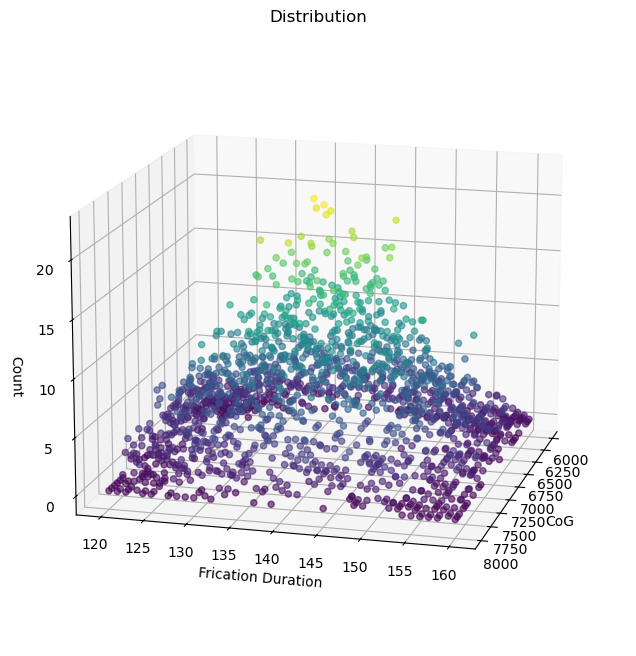

In [15]:
# covariance matrix (variance and covariance)
cov = [[250000, 0], [0, 100]]

# range and step
cog_min, cog_max, cog_step = mean_cog - 1000, mean_cog + 1000, 50
fd_min, fd_max, fd_step = mean_fd - 20, mean_fd + 20, 1

# possible values and grid
cog_vals = np.arange(cog_min, cog_max + cog_step, cog_step)
fd_vals = np.arange(fd_min, fd_max + fd_step, fd_step)

xx, yy = np.meshgrid(cog_vals, fd_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# normal distribution / gaussian distribution
rv = multivariate_normal([mean_cog, mean_fd], cov)

# probability for each grid point and normalization
probs = rv.pdf(grid_points)
probs /= probs.sum()

# sample generation
indices = np.random.choice(len(grid_points), size=sample_size, p=probs)
samples = grid_points[indices]

counts = np.bincount(indices, minlength=len(grid_points))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(grid_points[:, 0], grid_points[:, 1], counts, c=counts, cmap='viridis', marker='o', alpha=0.6)

ax.set_xlabel('CoG')
ax.set_ylabel('Frication Duration')
ax.set_zlabel('Count')
ax.set_title('Distribution')

ax.view_init(elev=15, azim=15)

plt.show()

In [6]:
# 6 new elements with uniform distribution [0, 1]
six_uni = np.random.uniform(0, 1, size=(sample_size, 6))

# total consonant duration of fixed value 150
con_dur = np.full((sample_size, 1), 150)

# zero values for vowel features
zeros = np.full((sample_size, 9), 0)

# all concatenated
consonants = np.hstack((samples, six_uni, con_dur, zeros))

### Vowel synthesis

nine features, with f0 randomly selected from {80, 300}, others fiexed

In [7]:
# f0
f0 = np.random.choice([80, 300], size=(sample_size, 1))

# vowel duration and intensity
vow_dur = np.full((sample_size, 1), 200)
intensity = np.full((sample_size, 1), 70)

fandb = np.array(fandb_vals).reshape(1, 6)
fandb = np.repeat(fandb, sample_size, axis=0)

# zero values for consonant features
vowels = np.hstack((zeros, f0, vow_dur, intensity, fandb))

### A csv file as guideline

In [8]:
element = [
    'cog', 'fri_dur', 'sta_dev', 'skewness', 'kurtosis', 'bur_amp', 'fri_ene', 'sil_dur', 'con_dur',
    'f0', 'vow_dur', 'intensity', 'f3', 'f1b', 'f2b', 'f3b', 'f1', 'f2'
]

explanation = [
    'center of gravity', 'frication duration', 'standard deviation', 'skewness', 'kurtosis', 
    'burst amplitude', 'frication energy', 'silence duration', 'consonant duration',
    'fundamental frequency', 'vowel duration', 'intensity', 'f3', 'bandwidth of f1', 'bandwidth of f2', 'bandwidth of f3', 'f1', 'f2'
]

val_range = [
    '3000-5000, 6000-8000 Hz', '30-70, 120-160 ms', '0-1', '0-1', '0-1',
    '0-1', '0-1', '0-1', '150 ms'
] + ['80, 300 Hz', '200 ms', '70 dB', '', '', '', '', '', '']


random = [ 
    'gaussian', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'fixed'
] + ['binary'] + ['fixed'] * 8

structure = pd.DataFrame({
    'element': element,
    'explanation': explanation, 
    'range': val_range,
    'random': random,
    'consonant_sample': consonants[0],
    'consonant': consonant,
    'vowel_sample': vowels[0],
    'vowel': vowel
})

file_name = os.path.join(data_dir, 'structure_sample.csv')
print(file_name)
# structure.to_csv(file_name, index=True)

/Users/shuhaoz19/Desktop/Workspace/ldl_projects/phoneme_gen/data/structure_sample.csv


### Save as 3*18 .npy

In [9]:
metadata = []

subdata_dir = os.path.join(data_dir, word)
os.makedirs(subdata_dir, exist_ok=True)

for i in range(sample_size):
    uid = word + f'_{i+1:04d}'
    filename = f'{uid}.npy'
    save_path = os.path.join(subdata_dir, filename)
    
    vcv = np.vstack([vowels[i], consonants[i], vowels[i]])

    np.save(save_path, vcv)
    
    cog = vcv[1][0]
    fri_dur = vcv[1][1]
    
    save_path_rel = os.path.relpath(save_path, start=work_dir)

    metadata.append({
        'uid': uid,
        'path': save_path_rel,
        'cog': cog,
        'fri_dur': fri_dur,
        'word': word
    })

metaframe = pd.DataFrame(metadata)

csv_name = word + '_meta.csv'
csv_path = os.path.join(data_dir, csv_name)
metaframe.to_csv(csv_path, index=False)

In [10]:
savetest = np.load(save_path)

print(savetest)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.00000000e+02 2.00000000e+02 7.00000000e+01
  3.20000000e+03 6.00000000e+01 9.00000000e+01 1.50000000e+02
  3.00000000e+02 2.50000000e+03]
 [7.00000000e+03 1.26000000e+02 6.42939390e-02 2.10809748e-01
  5.00606628e-01 2.54273435e-01 1.85085082e-02 9.60795917e-01
  1.50000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.00000000e+02 2.00000000e+02 7.00000000e+01
  3.20000000e+03 6.00000000e+01 9.00000000e+01 1.50000000e+02
  3.00000000e+02 2.50000000e+03]]
